<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


In [6]:
import os
ruta=os.getcwd()+'/data/'

## Task 2: Load and Inspect the S&P 500 Index Data

In [7]:
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',')
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 

In [8]:
merged_df=pd.merge(order_payments, orders, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, reviews, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, customer, how='left', left_on='customer_id', right_on='customer_id')
merged_df=pd.merge(merged_df, order_items, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, products, how='left', left_on='product_id', right_on='product_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix_x,seller_city_x,seller_state_x,seller_zip_code_prefix_y,seller_city_y,seller_state_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,...,800.0,17.0,27.0,17.0,13321.0,salto,SP,13321.0,salto,SP
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,...,150.0,16.0,6.0,11.0,4660.0,sao paulo,SP,4660.0,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,...,250.0,20.0,8.0,21.0,9015.0,santo andre,SP,9015.0,santo andre,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,1200.0,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP
4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,1200.0,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP


In [9]:
merged_df['ano_mes']=merged_df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+merged_df['order_purchase_timestamp'].str.split('-', expand=True)[1]
merged_df['ano_mes_dt'] = pd.to_datetime(merged_df['ano_mes'])
merged_df['fecha'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['Year']= merged_df['fecha'].dt.year
merged_df['mes']= merged_df['fecha'].dt.month
merged_df.ano_mes = merged_df.ano_mes.astype('category')
merged_df['codes']= merged_df.ano_mes.cat.codes
merged_df['total_pay'] = merged_df['price']+merged_df['freight_value']
# merged_df['ano_mes_dia'] = merged_df['order_purchase_timestamp'].str.split(' ', expand=True)[0]
# merged_df['ano_mes_dia_dt'] = merged_df.to_datetime(df['ano_mes_dia'])

In [10]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
estimated_time = pd.to_datetime(merged_df.order_estimated_delivery_date)
merged_df["late_delivery"] = delivered_time - estimated_time
merged_df["late_delivery"]=merged_df["late_delivery"]/np.timedelta64(1,"D")

In [11]:
late_deliveries_df = merged_df[merged_df.late_delivery > 0]
late_deliveries_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
12,esporte_lazer,2017-12-19 20:49:52,2017-12-18 00:00:00,1.867963
19,ferramentas_jardim,2018-04-26 16:38:53,2018-04-12 00:00:00,14.693669
52,cool_stuff,2017-11-07 20:38:45,2017-11-07 00:00:00,0.860243
60,pet_shop,2018-03-12 22:54:42,2018-03-08 00:00:00,4.954653
78,eletroportateis,2018-04-19 03:03:32,2018-03-23 00:00:00,27.127454
81,beleza_saude,2017-08-22 20:51:23,2017-08-22 00:00:00,0.869016
116,construcao_ferramentas_jardim,2017-10-24 15:56:55,2017-10-24 00:00:00,0.664525
139,pet_shop,2017-11-22 23:17:39,2017-11-10 00:00:00,12.970590
140,pet_shop,2017-11-22 23:17:39,2017-11-10 00:00:00,12.970590
151,perfumaria,2018-02-23 16:54:56,2018-02-21 00:00:00,2.704815


In [12]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
approved_time = pd.to_datetime(merged_df.order_approved_at)
merged_df["delivery_time"] = delivered_time - approved_time
merged_df["delivery_time"] = merged_df["delivery_time"]/np.timedelta64(1,"D")

In [13]:
delivery_time_df = merged_df[merged_df.delivery_time > 0]
delivery_time_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
0,casa_construcao,2018-05-09 17:36:51,2018-05-22 00:00:00,-12.266076
1,automotivo,2018-06-29 20:32:09,2018-07-16 00:00:00,-16.144340
2,perfumaria,2017-12-18 17:24:41,2018-01-04 00:00:00,-16.274525
3,cama_mesa_banho,2017-12-21 01:35:51,2018-01-04 00:00:00,-13.933438
4,cama_mesa_banho,2017-12-21 01:35:51,2018-01-04 00:00:00,-13.933438
5,cama_mesa_banho,2018-06-01 21:44:53,2018-06-13 00:00:00,-11.093831
6,cama_mesa_banho,2018-05-14 19:02:54,2018-05-23 00:00:00,-8.206319
7,cama_mesa_banho,2018-05-14 19:02:54,2018-05-23 00:00:00,-8.206319
8,utilidades_domesticas,2017-07-03 15:59:46,2017-07-17 00:00:00,-13.333495
9,perfumaria,2017-06-23 12:18:32,2017-06-26 00:00:00,-2.487130


In [14]:
orders1 = orders.copy()
orders1 = orders1[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
orders1['order_delivered_customer_date'] = pd.to_datetime(orders1['order_delivered_customer_date'])
orders1['order_estimated_delivery_date'] = pd.to_datetime(orders1['order_estimated_delivery_date'])
orders1['Estimated_Delivered'] = orders1['order_delivered_customer_date']-orders1['order_estimated_delivery_date']
orders1['Estimated_Delivered'] = orders1['Estimated_Delivered'].dt.days
orders1.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0


In [15]:
orders_reviews = pd.merge(orders1, reviews, on="order_id", how="left")
orders_reviews = orders_reviews[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'Estimated_Delivered', 'review_score']]
orders_reviews['Puntuality'] = np.where(orders_reviews['Estimated_Delivered'] <= 0, "Punctual", "Unpunctual")
orders_reviews.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered,review_score,Puntuality
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0,4,Punctual
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0,4,Punctual
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0,5,Punctual
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0,5,Punctual
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0,5,Punctual


In [16]:
Ventas_Fecha = orders_reviews[['Estimated_Delivered', 'review_score']]
Ventas_Fecha.head(10)

,Estimated_Delivered,review_score
0,-8.0,4
1,-6.0,4
2,-18.0,5
3,-13.0,5
4,-10.0,5
5,-6.0,4
6,NaN,2
7,-12.0,5
8,-32.0,1
9,-7.0,5


In [74]:
# Ventas_Fecha1 = Ventas_Fecha.groupby(['codes']).agg({'total_pay': ['sum']})   
# Ventas_Fecha1 = Ventas_Fecha1.reset_index()
# Ventas_Fecha1.columns = Ventas_Fecha1.columns.droplevel(1)
# Ventas_Fecha1.head()
# Ventas_Fecha1 = Ventas_Fecha
# Ventas_Fecha1.head()

Ventas_Fecha1 = Ventas_Fecha[Ventas_Fecha.index > 89999]
Ventas_Fecha1.head()

,Estimated_Delivered,review_score
90000,-29.0,5
90001,-13.0,4
90002,-31.0,4
90003,-11.0,5
90004,-22.0,4


In [56]:
# df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
# df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [75]:
Ventas_Fecha1.shape

(10000, 2)

In [76]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Ventas_Fecha1.review_score, y=Ventas_Fecha1.Estimated_Delivered,
                    mode='markers',
                    name='total_pay'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [77]:
df = Ventas_Fecha1
df.rename(columns = {'Estimated_Delivered':'date', 'review_score':'close'}, inplace = True) 
df.columns

Index(['date', 'close'], dtype='object')

In [78]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(8000, 2) (2000, 2)


In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [80]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [81]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(7970, 30, 1)


In [82]:
X_train

array([[[ 0.68240305],
        [-0.06217202],
        [-0.06217202],
        ...,
        [-2.29589721],
        [ 0.68240305],
        [-0.80674708]],

       [[-0.06217202],
        [-0.06217202],
        [ 0.68240305],
        ...,
        [ 0.68240305],
        [-0.80674708],
        [ 0.68240305]],

       [[-0.06217202],
        [ 0.68240305],
        [-0.06217202],
        ...,
        [-0.80674708],
        [ 0.68240305],
        [ 0.68240305]],

       ...,

       [[-0.80674708],
        [ 0.68240305],
        [ 0.68240305],
        ...,
        [-0.06217202],
        [-0.06217202],
        [ 0.68240305]],

       [[ 0.68240305],
        [ 0.68240305],
        [ 0.68240305],
        ...,
        [-0.06217202],
        [ 0.68240305],
        [-1.55132214]],

       [[ 0.68240305],
        [ 0.68240305],
        [ 0.68240305],
        ...,
        [ 0.68240305],
        [-1.55132214],
        [ 0.68240305]]])

## Task 5: Build an LSTM Autoencoder

In [83]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [85]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/50
225/225 [==============================] - 43s 154ms/step - loss: 0.7394 - val_loss: 0.6872
Epoch 2/50
225/225 [==============================] - 32s 144ms/step - loss: 0.7118 - val_loss: 0.6819
Epoch 3/50
225/225 [==============================] - 33s 146ms/step - loss: 0.7071 - val_loss: 0.6816
Epoch 4/50
225/225 [==============================] - 33s 145ms/step - loss: 0.7056 - val_loss: 0.6808
Epoch 5/50
225/225 [==============================] - 33s 147ms/step - loss: 0.7037 - val_loss: 0.6806
Epoch 6/50
225/225 [==============================] - 34s 150ms/step - loss: 0.7025 - val_loss: 0.6801
Epoch 7/50
225/225 [==============================] - 33s 148ms/step - loss: 0.7018 - val_loss: 0.6806
Epoch 8/50
225/225 [==============================] - 34s 151ms/step - loss: 0.7016 - val_loss: 0.6804
Epoch 9/50
225/225 [==============================] - 34s 149ms/step - loss: 0.7013 - val_loss: 0.6799
Epoch 10/50
225/225 [==============================] - 33s 145ms/step - l

## Task 7: Plot Metrics and Evaluate the Model

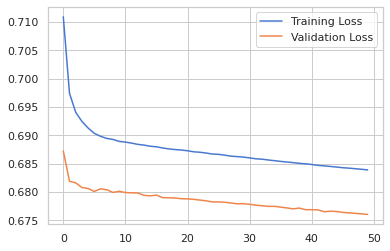

In [86]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [87]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [88]:
model.evaluate(X_test, y_test)

62/62 [==============================] - 5s 77ms/step - loss: 0.6817


0.6817044615745544

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



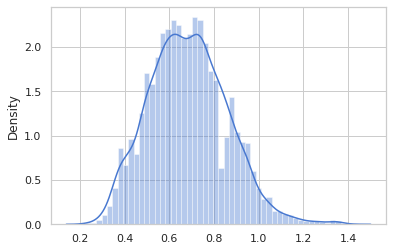

In [89]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [90]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



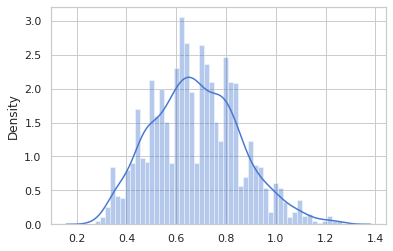

In [91]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [92]:
THRESHOLD = 0.53

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='markers',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [94]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
98030,-6.0,-2.295897,0.843856,0.53,True
98031,-8.0,-0.062172,0.942909,0.53,True
98032,-11.0,-0.062172,0.967518,0.53,True
98033,-10.0,0.682403,0.893046,0.53,True
98034,-18.0,0.682403,0.868458,0.53,True


In [95]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='markers',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()